In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys
import os
import blosc
import pickle

import numpy as np
import pandas as pd

from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from tensorflow.contrib.layers import xavier_initializer_conv2d
# from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset, F, V, B
from dataset import Batch, action, model, inbatch_parallel
from standard_models.resnet import ResNetModel
from task_03.my_batch import MnistBatch
from task_03.my_batch import draw_stats

In [ ]:
loss_results = defaultdict(list)
test_loss_results = defaultdict(list)
acc_results = defaultdict(list)
test_acc_results = defaultdict(list)

In [3]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
# src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

In [4]:
full_labs = full_labs[:, :2]
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

In [5]:
data = pd.DataFrame(full_labs)
indices_one = data[data[1] == 1.0].index.values
indices_zero =  data[data[0] == 1.0].index.values

In [6]:
indices_one.shape

(7314,)

In [7]:
indices_zero.shape

(6424,)

In [8]:
train_idx = np.hstack((indices_zero, indices_one))

In [9]:
mnistset = Dataset(train_idx, MnistBatch)

In [10]:
mnistset.cv_split([0.9, 0.1])

In [11]:
mnistset.train

In [12]:
# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

# bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

In [13]:
SIZE = 28
BATCH_SIZE = 100
NUM_ITERS = 400

In [14]:
s = [1, 2, 3]
[-1] + s

[-1, 1, 2, 3]

In [15]:
def focal_loss(targets, predictions, gamma=0.5):
    print(gamma)
    probs = tf.nn.softmax(predictions)
    focal_factor = tf.pow((1 - probs), gamma)
    tuned_predictions = tf.exp(focal_factor) * predictions
    return tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=tuned_predictions)

In [16]:
config={'input': {'shape': [28, 28, 1], 'n_classes': 2},
        'length_factor': [3, 0, 0, 0],
        'widening_factor': 4,
        'layout': 'ca',
        'bottleneck':False,
        'max_pool': False,
        'loss': partial(focal_loss, gamma=1.),
        'conv_params': {'conv': {'kernel_initializer': tf.contrib.layers.variance_scaling_initializer(factor=2.0), \
                                 'bias_initializer': tf.contrib.layers.variance_scaling_initializer(factor=2.0)}},
        'optimizer': {'name':'Adam', 'use_locking': True}
       }

In [39]:
def test_focal_loss(gammas, loss_results, test_loss_results, acc_results, test_acc_results):
    for index in range(len(gammas)):
        config['loss'] = partial(focal_loss, gamma=gammas[index])
        if index == 0 or index == 1:
            continue
        if index == 2:
            continue
            
        ppl = (mnistset.train.p
                         .load(src=src, fmt='ndarray')
                         .init_variable('acc_history', init_on_each_run=list)
                         .init_variable('loss_history', init_on_each_run=list)
                         .init_model('dynamic', ResNetModel, 'MyResNet', config)
                         .train_model('MyResNet', fetches=['accuracy', 'loss'], feed_dict={'input_images': B('images'),
                                             'targets': B('labels')},
                                     append_to=[V('acc_history'), V('loss_history')]))
        
        ppl_test = (mnistset.test.p
                        .load(src=src, fmt='ndarray')
                        .init_variable('test_acc_history', init_on_each_run=list)
                        .init_variable('test_loss_history', init_on_each_run=list)
                        .import_model('MyResNet', ppl)
                        .predict_model('MyResNet', fetches=['accuracy', 'loss'], feed_dict={'input_images': B('images'),
                                                                                  'targets': B('labels')},
                                       append_to=[V('test_acc_history'), V('test_loss_history')]))
        for i in tqdm(range(400)):
            ppl.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
            ppl_test.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
            
        
        loss_results[str(index)] = ppl.get_variable('loss_history')
        test_loss_results[str(index)] = ppl_test.get_variable('test_loss_history')
        
        acc_results[str(index)] = ppl.get_variable('acc_history')
        test_acc_results[str(index)] = ppl_test.get_variable('test_acc_history')
        

In [40]:
test_focal_loss([0.0, 0.5, 1.0, 2.0], loss_results, test_loss_results, acc_results, test_acc_results)

2.0



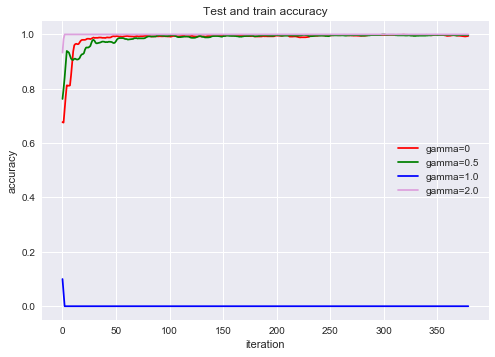

In [43]:
draw_stats([test_acc_results['0'], test_acc_results['1'], test_acc_results['2'], test_acc_results['3']], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test and train accuracy')

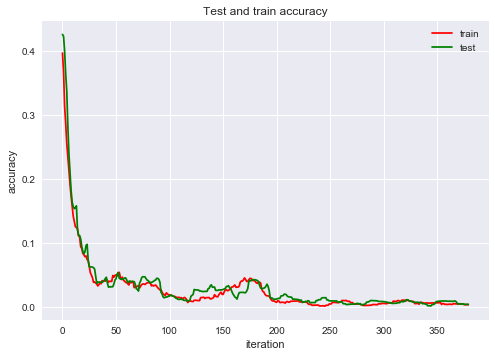

In [50]:
draw_stats([loss_results['2'], test_loss_results['2']], \
           ['train', 'test'], 'Test and train accuracy')

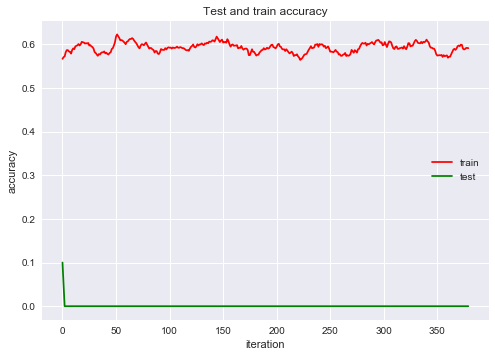

In [45]:
draw_stats([acc_results['2'], test_acc_results['2']], \
           ['train', 'test'], 'Test and train accuracy')

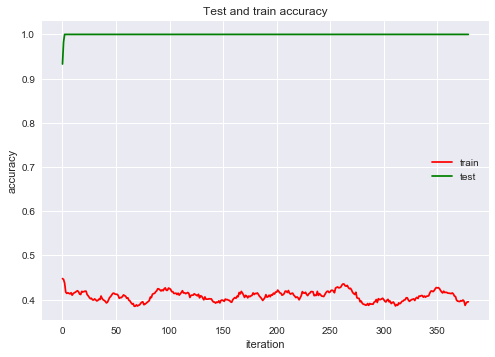

In [49]:
draw_stats([acc_results['3'], test_acc_results['3']], \
           ['train', 'test'], 'Test and train accuracy')

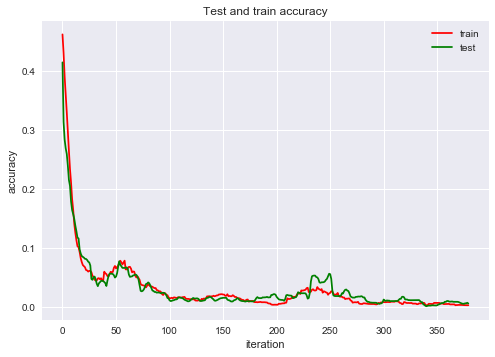

In [51]:
draw_stats([loss_results['3'], test_loss_results['3']], \
           ['train', 'test'], 'Test and train accuracy')

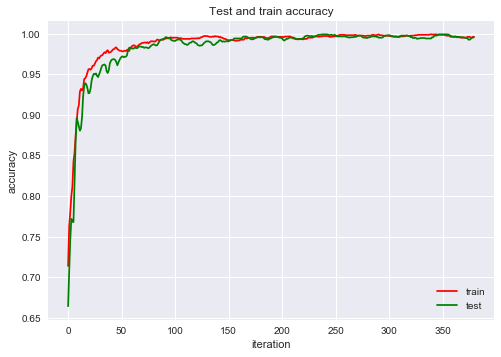

In [203]:
draw_stats([ppl.get_variable('acc_history'), ppl_test.get_variable('test_acc_history')], \
           ['train', 'test'], 'Test and train accuracy')

In [208]:
test_loss_results = defaultdict(list)
acc_results = defaultdict(list)
test_acc_results = defaultdict(list)

In [209]:
test_loss_results['0'] = ppl_test.get_variable('loss_history')
acc_results['0'] = ppl.get_variable('acc_history')
test_acc_results['0'] = ppl_test.get_variable('test_acc_history')

In [210]:
with open("test_loss_results.txt", "wb") as a:
    pickle.dump(test_loss_results, a)
    
with open("acc_results.txt", "wb") as a:
    pickle.dump(acc_results, a)

with open("test_acc_results.txt", "wb") as a:
    pickle.dump(test_acc_results, a)